In [1]:
!pip install Augmentor
!pip install tensorflow_addons
import os
from os import path
import random
import numpy as np
import pandas as pd
import cv2
import Augmentor 
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras import layers ,Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,SeparableConv2D, MaxPooling2D,MaxPool2D, Dense,Add, Flatten,GlobalAvgPool2D
from tensorflow.keras.layers import Dropout,GlobalAveragePooling2D,BatchNormalization, Input 
from tensorflow.keras.layers import ReLU,DepthwiseConv2D ,AvgPool2D,concatenate ,ReLU
from keras.preprocessing import image
from tensorflow_addons.optimizers import CyclicalLearningRate

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
# split
All_Data = tf.keras.utils.image_dataset_from_directory(
  "/kaggle/input/seat-belt2/Seat_Belt2/Train",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=16,
    image_size=(256, 256)
)

Found 7017 files belonging to 2 classes.


In [3]:
print(len(All_Data))

439


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


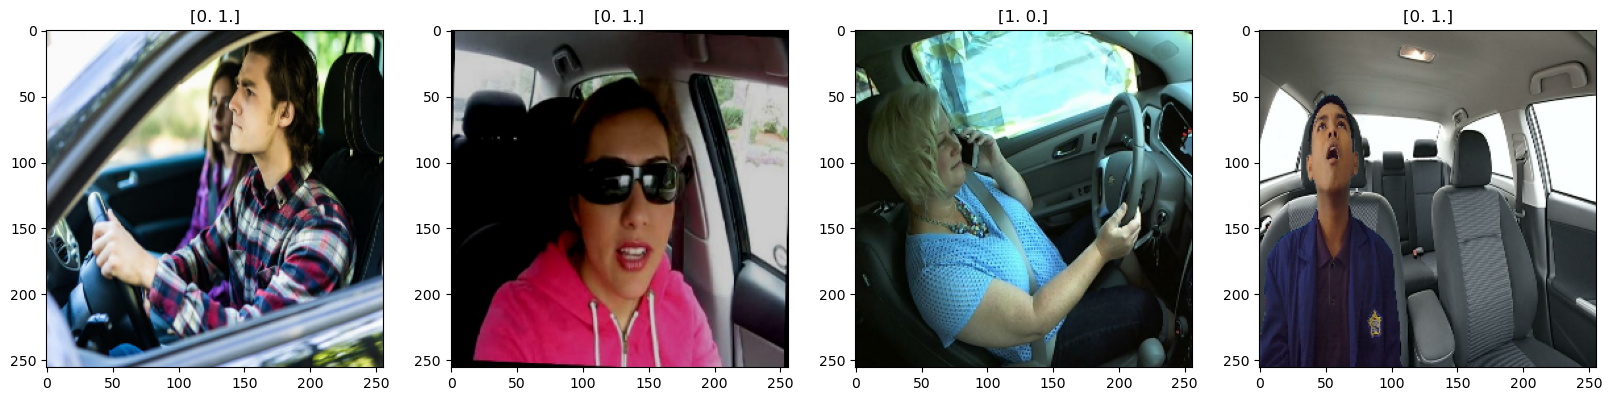

In [5]:
# visualize some images with labeles
data_iterator = All_Data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
    
# scaling the images
All_Data = All_Data.map(lambda x,y: (x/255, y))

In [6]:
train_size = 352
val_size =87

train = All_Data.take(train_size)
val = All_Data.skip(train_size).take(val_size)

In [7]:
print(len(train))
print(len(val))

352
87


In [8]:
vgg16 = tf.keras.applications.VGG16(include_top=False,weights='imagenet',input_shape=(256,256,3))

model = keras.Sequential()
model.add(vgg16)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(2, activation='softmax'))

58889256/58889256 [==============================] - 1s 0us/step


In [9]:
cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=3e-7,
 maximal_learning_rate=0.0001,
 step_size=len(train),
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

optimizer = tf.keras.optimizers.Adam(learning_rate = cyclical_learning_rate, clipvalue=0.1)
                                 
model.compile(loss="categorical_crossentropy",
                  optimizer =optimizer, metrics=["accuracy"])

In [10]:
# tf.random.set_seed(5)
history = model.fit(x = train, validation_data = val,epochs = 2,batch_size=16)
#,callbacks=model_checkpoint_callback)

Epoch 1/2
352/352 [==============================] - 88s 202ms/step - loss: 0.1230 - accuracy: 0.9487 - val_loss: 5.5074e-04 - val_accuracy: 1.0000
Epoch 2/2
352/352 [==============================] - 89s 253ms/step - loss: 5.3862e-05 - accuracy: 1.0000 - val_loss: 1.3806e-05 - val_accuracy: 1.0000


In [11]:
def drow_stats(hist):
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

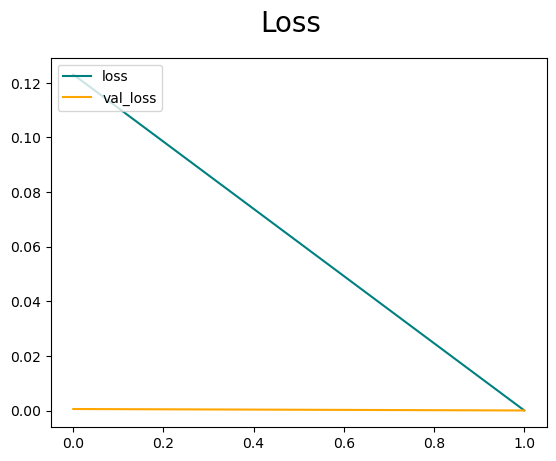

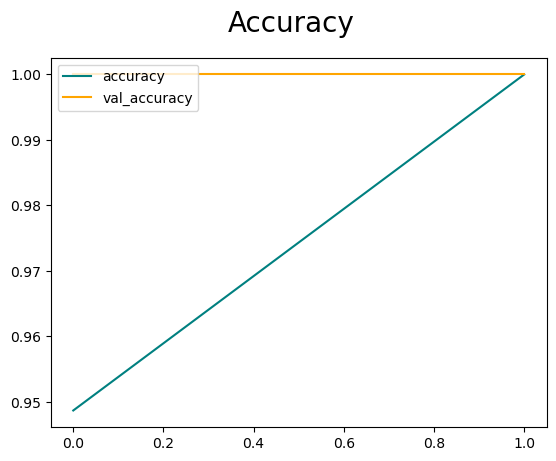

In [12]:
drow_stats(history)

In [13]:
Test_Data = tf.keras.utils.image_dataset_from_directory(
  "/kaggle/input/seat-belt2/Seat_Belt2/Test",
    label_mode='categorical',
    color_mode='rgb',
    batch_size=16,
    image_size=(256, 256)
)

Found 1600 files belonging to 2 classes.


In [14]:
print(len(Test_Data))

100


In [15]:
model.evaluate(Test_Data)

100/100 [==============================] - 8s 71ms/step - loss: 0.3211 - accuracy: 0.9987


[0.32108405232429504, 0.9987499713897705]

[3700, 3318]


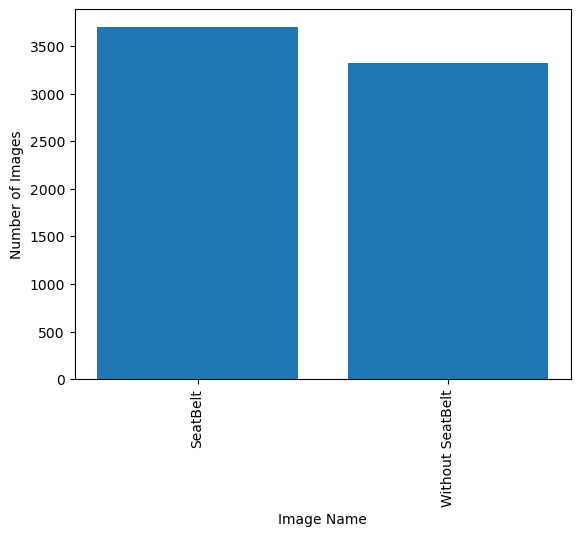

In [16]:
# Number of data per class Train
# image = "/kaggle/input/Driver-Behaviour1/New_Driver_Behaviour/train/c0"
# print(image)
# px.histogram(name_images,number_images)
# px.xlabel('name of images')
# px.ylabel('number_images')
# px.show()
import plotly.express as px
number_images = [3700, 3318]
name_images = ["SeatBelt", "Without SeatBelt"]
print(number_images)
plt.bar(name_images, number_images)
plt.xticks(rotation=90)
plt.xlabel('Image Name')
plt.ylabel('Number of Images')
plt.show()

[800, 800]


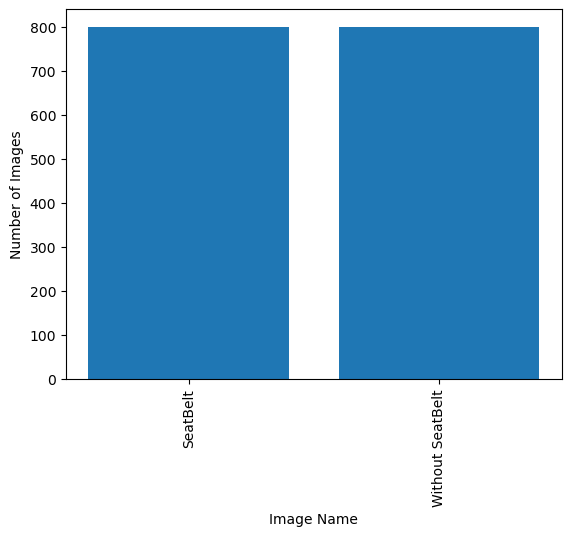

In [17]:
# Number of data per class Test
# image = "/kaggle/input/Driver-Behaviour1/New_Driver_Behaviour/train/c0"
# print(image)
# px.histogram(name_images,number_images)
# px.xlabel('name of images')
# px.ylabel('number_images')
# px.show()
import plotly.express as px
number_images = [800, 800]
name_images = ["SeatBelt", "Without SeatBelt"]
print(number_images)
plt.bar(name_images, number_images)
plt.xticks(rotation=90)
plt.xlabel('Image Name')
plt.ylabel('Number of Images')
plt.show()

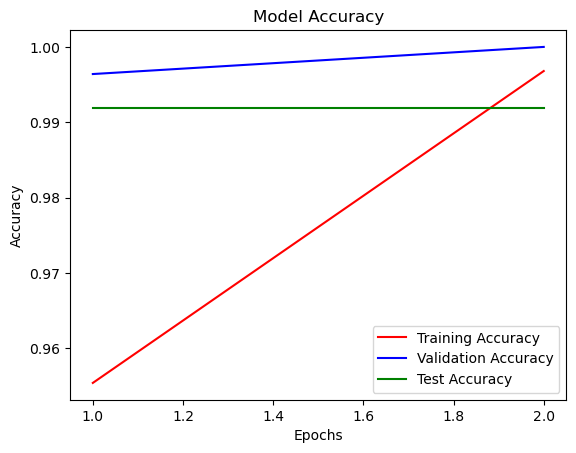

In [18]:
import matplotlib.pyplot as plt

# Generate data for the plot
train_accuracy = [0.9554, 0.9968]
validation_accuracy = [0.9964, 1.0000]
test_accuracy = [0.9919,0.9919]
epochs = [1, 2]

# Plot the data
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
plt.plot(epochs, test_accuracy, 'g', label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# model.save("Seatbelt_VGG16(100).h5")